In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def elementWiseMin(a1, a2):
    output = np.array([0, 0, 0])
    for i in range(3):
        output[i] = min(a1[i], a2[i])
    return output

def elementWiseMax(a1, a2):
    output = np.array([0, 0, 0])
    for i in range(3):
        output[i] = max(a1[i], a2[i])
    return output

def anArrivalVector(a1_avg, a2_avg, a3_avg, seed):
    np.random.seed(seed)
    return np.array([np.random.poisson(a1_avg), np.random.poisson(a2_avg), np.random.poisson(a3_avg)])
    # return np.array([np.random.binomial(n = 100, p = a1_avg / 100), np.random.binomial(n = 3, p = a2_avg / 3), np.random.binomial(n = 25, p = a3_avg / 25)]) 

def chooseEpsilonGreedyServiceConfiguration(s, Q, q, epsilon):
    if np.random.choice(2, p = [epsilon, 1 - epsilon]) == 1: # when we need to use the greedy policy with respect to Q
        if Q[q[0], q[1], q[2], 0] <= Q[q[0], q[1], q[2], 1]:
            s[0] = s[1] = 1
            return
        s[2] = 1
        return
    # when we need to use the random policy
    if np.random.choice(2) == 0:
        s[0] = s[1] = 1
        return
    s[2] = 1

def chooseGreedyServiceConfiguration(s, Q, q):
    if Q[q[0], q[1], q[2], 0] <= Q[q[0], q[1], q[2], 1]:
        s[0] = s[1] = 1
        return
    s[2] = 1

def chooseRandomServiceConfiguration(s):
    if np.random.choice(2) == 0:
        s[0] = s[1] = 1
        return
    s[2] = 1

def chooseMaxWeightServiceConfiguration(s, q):
    if q[0] + q[1] >= q[2]:
        s[0] = s[1] = 1
        return
    s[2] = 1

def chooseEpsilonMaxWeightServiceConfiguration(s, q, epsilon):
    if np.random.choice(2, p = [epsilon, 1 - epsilon]) == 1: # when we need to use the MaxWeight policy
        chooseMaxWeightServiceConfiguration(s, q)
        return
    # when we need to use the random policy
    chooseRandomServiceConfiguration(s)

def chooseMaxSizeCenterConfiguration(s, q):
    if q[2] == 0:
        s[0] = s[1] = 1
        return
    if q[0] == 0 or q[1] == 0:
        s[2] = 1
        return
    s[0] = s[1] = 1

def chooseEpsilonMaxSizeCenterServiceConfiguration(s, q, epsilon):
    if np.random.choice(2, p = [epsilon, 1 - epsilon]) == 1: # when we need to use the MaxSizeCenter policy
        chooseMaxSizeCenterConfiguration(s, q)
        return
    # when we need to use the random policy
    chooseRandomServiceConfiguration(s)

def numberOfZeroValueStateActionPairs(Q):
    output = 0
    for i in range(c + 1):
        for j in range(c + 1):
            for k in range(c + 1):
                for a in range(2):
                    if Q[i, j, k, a] == 0:
                        output += 1
    return output

def steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q):
    
    # simulate 500,000 times, with q1(0) = q2(0) = q3(0) = 0
    # discard first 100,000 samples to ensure steady state
    
    q1, q2, q3 = np.zeros(int(5e5) + 1), np.zeros(int(5e5) + 1), np.zeros(int(5e5) + 1)
    q1_output, q2_output, q3_output = np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5))

    for t in range(1, int(5e5) + 1):
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, 2*t)
        s = np.zeros(3)
        chooseGreedyServiceConfiguration(s, Q, np.array([int(q1[t - 1]), int(q2[t - 1]), int(q3[t - 1])]))
        q1[t], q2[t], q3[t] = min(max(q1[t - 1] + a[0] - s[0], 0), c), min(max(q2[t - 1] + a[1] - s[1], 0), c), min(max(q3[t - 1] + a[2] - s[2], 0), c)

        if t > 1e5:
            q1_output[t - int(1e5) - 1], q2_output[t - int(1e5) - 1], q3_output[t - int(1e5) - 1] = q1[t], q2[t], q3[t]

    return np.average(q1_output + q2_output + q3_output)

In [3]:
# relative-value-iteration q-learning with behavior policy = random and f(Q) = average of all state-action pairs' Q values

def averageTotalQueueLengthUsingRVIQLearning(numOfIterations, alpha):

    # initialize current states q and action-value estimates Q at time t = 0

    q = np.array([0, 0, 0])
    Q = np.zeros((c + 1, c + 1, c + 1, 2)) # the first 3 dimensions together represent states q, while the last represents actions s
                                           # the first action is [1, 1, 0], and the second action is [0, 0, 1]
    num_avg = int(0.2 * numOfIterations)
    Q_avg = np.zeros((c + 1, c + 1, c + 1, 2)) # the average Q function over the last num_avg iterations
    t_avg = 1

    # update Q numOfIterations times (with the first one being trivial)

    for t in range(1, numOfIterations + 1):
        # right now we've got q(t - 1)
        s = np.array([0, 0, 0])
        chooseRandomServiceConfiguration(s) # choose service configuration s(t - 1) for the interval [t - 1, t]
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, t) # generate arrival configuration a(t - 1) for the interval [t - 1, t]
        r = sum(q) # compute current reward r(t - 1)
        q_t_minus_1 = q # store q(t - 1)
        q = elementWiseMin(elementWiseMax(q + a - s, np.array([0, 0, 0])), np.array([c, c, c]))

        # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t), .), t, r(t - 1), and Q(q(t - 1), s(t - 1))
        Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]] += alpha * (r + min(Q[q[0], q[1], q[2], 0], Q[q[0], q[1], q[2], 1]) - ((1 / (2 * (c + 1) ** 3)) * np.sum(Q)) - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]])
    
        if t > numOfIterations - num_avg:
                Q_avg = (1 - 1 / t_avg) * Q_avg + 1 / t_avg * Q
                t_avg += 1
    
    numOfIterationsDividedByOneMillion = int(numOfIterations / 1e6)
    print('For alpha = %(alpha)s and numOfIterations = %(numOfIterationsDividedByOneMillion)se6, RVI q-learning gives' % locals())
    print('numberOfZeroValueStateActionPairs =', numberOfZeroValueStateActionPairs(Q_avg), end = ' and ')
    temp = steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q_avg)
    print('average total queue length \u2248', temp, end = '\n\n')
    return temp

# differential q-learning with behavior policy = random

def averageTotalQueueLengthUsingDifferentialQLearning(eta, numOfIterations, alpha):
    
    # initialize current states q, past average reward m, and action-value estimates Q at time t = 0
    
    q = np.array([0, 0, 0])
    m = 0
    Q = np.zeros((c + 1, c + 1, c + 1, 2)) # the first 3 dimensions together represent states q, while the last represents actions s
                                           # the first action is [1, 1, 0], and the second action is [0, 0, 1]
    num_avg = int(0.2 * numOfIterations)
    Q_avg = np.zeros((c + 1, c + 1, c + 1, 2)) # the average Q function over the last num_avg iterations
    t_avg = 1

    # update Q numOfIterations times (with the first one being trivial)

    for t in range(1, numOfIterations + 1):
        # right now we've got q(t - 1)
        s = np.array([0, 0, 0])
        chooseRandomServiceConfiguration(s) # choose service configuration s(t - 1) for the interval [t - 1, t]
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, t) # generate arrival configuration a(t - 1) for the interval [t - 1, t]
        r = sum(q) # compute current reward r(t - 1)
        q_t_minus_1 = q # store q(t - 1)
        q = elementWiseMax(q + a - s, np.array([0, 0, 0]))
        q = elementWiseMin(q, np.array([c, c, c])) # finish computing q(t)
        m_t_minus_1 = m # store m(t - 1)
        
        # compute past average reward m(t) based on t, m(t - 1), current reward r(t - 1), and Q(q(t), .)
        m = m  + eta * alpha * (r - m_t_minus_1 + min(Q[q[0], q[1], q[2], 0], Q[q[0], q[1], q[2], 1]) - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]])

        # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t - 1), s(t - 1)), Q(q(t), .), t, r(t - 1), and m(t - 1)
        Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]] += alpha * (r - m_t_minus_1 + min(Q[q[0], q[1], q[2], 0], Q[q[0], q[1], q[2], 1]) - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]])
        
        if t > numOfIterations - num_avg:
            Q_avg = (1 - 1 / t_avg) * Q_avg + 1 / t_avg * Q
            t_avg += 1

    numOfIterationsDividedByOneMillion = int(numOfIterations / 1e6)
    print('For eta = %(eta)s, alpha = %(alpha)s, and numOfIterations = %(numOfIterationsDividedByOneMillion)se6, differential q-learning gives' % locals())
    print('numberOfZeroValueStateActionPairs =', numberOfZeroValueStateActionPairs(Q_avg), end = ' and ')
    temp = steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q_avg)
    print('average total queue length \u2248', temp, end = '\n\n')
    return temp

# discounted-cost q-learning with behavior policy = random

def averageTotalQueueLengthUsingDiscountedCostQLearning(gamma, numOfIterations, alpha):

    # initialize current states q and action-value estimates Q at time t = 0

    q = np.array([0, 0, 0])
    Q = np.zeros((c + 1, c + 1, c + 1, 2)) # the first 3 dimensions together represent states q, while the last represents actions s
                                           # the first action is [1, 1, 0], and the second action is [0, 0, 1]
    num_avg = int(0.2 * numOfIterations)
    Q_avg = np.zeros((c + 1, c + 1, c + 1, 2)) # the average Q function over the last num_avg iterations
    t_avg = 1

    # update Q numOfIterations times (with the first one being trivial)

    for t in range(1, numOfIterations + 1):
        # right now we've got q(t - 1)
        s = np.array([0, 0, 0])
        chooseRandomServiceConfiguration(s) # choose service configuration s(t - 1) for the interval [t - 1, t]
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, t) # generate arrival configuration a(t - 1) for the interval [t - 1, t]
        r = sum(q) # compute current reward r(t - 1)
        q_t_minus_1 = q # store q(t - 1)
        q = elementWiseMin(elementWiseMax(q + a - s, np.array([0, 0, 0])), np.array([c, c, c]))

        # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t), .), t, r(t - 1), and Q(q(t - 1), s(t - 1))
        Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]] += alpha * (r + gamma * min(Q[q[0], q[1], q[2], 0], Q[q[0], q[1], q[2], 1]) - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]])
    
        if t > numOfIterations - num_avg:
                Q_avg = (1 - 1 / t_avg) * Q_avg + 1 / t_avg * Q
                t_avg += 1
    
    numOfIterationsDividedByOneMillion = int(numOfIterations / 1e6)
    print('For gamma = %(gamma)s, alpha = %(alpha)s, and numOfIterations = %(numOfIterationsDividedByOneMillion)se6, discounted-cost q-learning gives' % locals())
    print('numberOfZeroValueStateActionPairs =', numberOfZeroValueStateActionPairs(Q_avg), end = ' and ')
    temp = steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q_avg)
    print('average total queue length \u2248', temp, end = '\n\n')
    return temp

# average-cost sarsa with behavior policy = epsilon-greedy
def averageTotalQueueLengthUsingAverageCostSarsa(epsilon, numOfIterations, alpha):
    
    # initialize current states q, past average reward m, and action-value estimates Q at time t = 0

    q = np.array([0, 0, 0])
    m = 0
    Q = np.zeros((c + 1, c + 1, c + 1, 2)) # the first 3 dimensions together represent states q, while the last represents actions s
                                           # the first action is [1, 1, 0], and the second action is [0, 0, 1]
    num_avg = int(0.2 * numOfIterations)
    Q_avg = np.zeros((c + 1, c + 1, c + 1, 2)) # the average Q function over the last num_avg iterations
    t_avg = 1

    # choose action (service configuration) s at time t = 0
    s = np.array([0, 0, 0])
    chooseEpsilonGreedyServiceConfiguration(s, Q, q, epsilon) # determine s(0)

    # update Q 10,000,000 times (with the first one being trivial)

    for t in range(1, numOfIterations + 1):
        # right now we've got q(t - 1), s(t - 1), and m(t - 1)
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, t) # generate arrival configuration a(t - 1) for the interval [t - 1, t]
        r = sum(q) # compute current reward r(t - 1)
        m_t_minus_1 = m # store m(t - 1)
        m = (1 - 1 / t) * m  + 1 / t * r # compute past average reward m(t) based on t, m(t - 1), and current reward r(t - 1)
        q_t_minus_1 = q # store q(t - 1)
        q = elementWiseMax(q + a - s, np.array([0, 0, 0]))
        q = elementWiseMin(q, np.array([c, c, c])) # finish computing q(t)
        s_t_minus_1 = s # store s(t - 1)
        s = np.array([0, 0, 0])
        chooseEpsilonGreedyServiceConfiguration(s, Q, q, epsilon) # determine s(t)

        # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t - 1), s(t - 1)), t, r(t - 1), m(t - 1), and Q(q(t), s(t))
        Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s_t_minus_1[2]] += alpha * (r - m_t_minus_1 + Q[q[0], q[1], q[2], s[2]] - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s_t_minus_1[2]])
    
        if t > numOfIterations - num_avg:
                Q_avg = (1 - 1 / t_avg) * Q_avg + 1 / t_avg * Q
                t_avg += 1
    
    numOfIterationsDividedByOneMillion = int(numOfIterations / 1e6)
    print('For epsilon = %(epsilon)s, alpha = %(alpha)s, and numOfIterations = %(numOfIterationsDividedByOneMillion)se6, average-cost Sarsa gives' % locals())
    print('numberOfZeroValueStateActionPairs =', numberOfZeroValueStateActionPairs(Q_avg), end = ' and ')
    temp = steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q_avg)
    print('average total queue length \u2248', temp, end = '\n\n')
    return temp

def averageTotalQueueLengthUsingRandomPolicy():
    # random policy:
    # during each interval [t - 1, t], choose a random configuration

    # simulate 500,000 times, with q1(0) = q2(0) = q3(0) = 0
    # discard first 100,000 samples to ensure steady state

    q1, q2, q3 = np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1))
    q1_output, q2_output, q3_output = np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5))

    for t in range(1, int(5e5 + 1)):
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, 2*t)
        s = np.zeros(3)
        chooseRandomServiceConfiguration(s)
        q1[t], q2[t], q3[t] = min(max(q1[t - 1] + a[0] - s[0], 0), c), min(max(q2[t - 1] + a[1] - s[1], 0), c), min(max(q3[t - 1] + a[2] - s[2], 0), c)

        if t > 1e5:
            q1_output[t - int(1e5) - 1], q2_output[t - int(1e5) - 1], q3_output[t - int(1e5) - 1] = q1[t], q2[t], q3[t]

    print('Random policy gives')
    print('average total queue length \u2248', np.average(q1_output + q2_output + q3_output), end = '\n\n')
    return np.average(q1_output + q2_output + q3_output)

def averageTotalQueueLengthUsingMaxWeightPolicy():
    # MaxWeight policy:
    # during each interval [t - 1, t], choose a configuration such that the queues being served have the maximum combined size

    # simulate 500,000 times, with q1(0) = q2(0) = q3(0) = 0
    # discard first 100,000 samples to ensure steady state

    q1, q2, q3 = np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1))
    q1_output, q2_output, q3_output = np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5))

    for t in range(1, int(5e5 + 1)):
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, 2*t)
        s = np.zeros(3)
        chooseMaxWeightServiceConfiguration(s, np.array([int(q1[t - 1]), int(q2[t - 1]), int(q3[t - 1])]))
        q1[t], q2[t], q3[t] = min(max(q1[t - 1] + a[0] - s[0], 0), c), min(max(q2[t - 1] + a[1] - s[1], 0), c), min(max(q3[t - 1] + a[2] - s[2], 0), c)

        if t > 1e5:
            q1_output[t - int(1e5) - 1], q2_output[t - int(1e5) - 1], q3_output[t - int(1e5) - 1] = q1[t], q2[t], q3[t]

    print('MaxWeight policy gives')
    print('average total queue length \u2248', np.average(q1_output + q2_output + q3_output), end = '\n\n')
    return np.average(q1_output + q2_output + q3_output)

def averageTotalQueueLengthUsingMaxSizeCenterPolicy():
    # MaxWeight policy:
    # during each interval [t - 1, t], choose a configuration such that the queues being served have the maximum combined size

    # simulate 500,000 times, with q1(0) = q2(0) = q3(0) = 0
    # discard first 100,000 samples to ensure steady state

    q1, q2, q3 = np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1))
    q1_output, q2_output, q3_output = np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5))

    for t in range(1, int(5e5 + 1)):
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, 2*t)
        s = np.zeros(3)
        chooseMaxSizeCenterConfiguration(s, np.array([int(q1[t - 1]), int(q2[t - 1]), int(q3[t - 1])]))
        q1[t], q2[t], q3[t] = min(max(q1[t - 1] + a[0] - s[0], 0), c), min(max(q2[t - 1] + a[1] - s[1], 0), c), min(max(q3[t - 1] + a[2] - s[2], 0), c)

        if t > 1e5:
            q1_output[t - int(1e5) - 1], q2_output[t - int(1e5) - 1], q3_output[t - int(1e5) - 1] = q1[t], q2[t], q3[t]
        
    print('MaxSizeCenter policy gives')
    print('average total queue length \u2248', np.average(q1_output + q2_output + q3_output), end = '\n\n')
    return np.average(q1_output + q2_output + q3_output)

In [4]:
def performanceComparison(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa):
    avg_total_q1 = np.zeros(3)
    avg_total_q1[0] = averageTotalQueueLengthUsingRandomPolicy()
    avg_total_q1[1] = averageTotalQueueLengthUsingMaxWeightPolicy()
    avg_total_q1[2] = averageTotalQueueLengthUsingMaxSizeCenterPolicy()
    avg_total_q2 = np.zeros(1)
    avg_total_q2[0] = averageTotalQueueLengthUsingRVIQLearning(numOfIterationsForRVIDiff, 0.01)
    avg_total_q3 = np.zeros(1)
    avg_total_q3[0] = averageTotalQueueLengthUsingDifferentialQLearning(0.1, numOfIterationsForRVIDiff, 0.01)
    avg_total_q4 = np.zeros(1)
    avg_total_q4[0] = averageTotalQueueLengthUsingDiscountedCostQLearning(0.99, numOfIterationsForDis, 0.01)
    avg_total_q5 = np.zeros(1)
    avg_total_q5[0] = averageTotalQueueLengthUsingAverageCostSarsa(0.1, numOfIterationsForSarsa, 0.01)
    
    numOfIterationsForRVIDiffDividedByOneMillion = int(numOfIterationsForRVIDiff / 1e6)
    numOfIterationsForDisDividedByOneMillion = int(numOfIterationsForDis / 1e6)
    numOfIterationsForSarsaDividedByOneMillion = int(numOfIterationsForSarsa / 1e6)
    methods = np.array(['Random Policy', 'MaxWeight Policy', 'MaxSizeCenter Policy', 'Greedy Policy w/ RVI Q-learning', 'Greedy Policy w/ Diff Q-learning', 'Greedy Policy w/ Discounted-cost Q-learning', 'Greedy Policy w/ Avg-cost Sarsa'])
    positions1 = np.array([0, 0.6, 1.2])
    positions2 = np.array([2])
    positions3 = np.array([2.9])
    positions4 = np.array([3.9])
    positions5 = np.array([4.9])
    positions = np.array([0, 0.6, 1.2, 2, 2.9, 3.9, 4.9])
    plt.figure(figsize = (21, 14))
    plt.bar(positions1, avg_total_q1, width = 0.4, label = None)
    plt.bar(positions2, avg_total_q2, width = 0.4, label = 'RVI Q-learning w/ Behavior Policy = Random, f(Q) = Average Q Value, \u03B1 = 0.01, and numOfIterations = %(numOfIterationsForRVIDiffDividedByOneMillion)se6' % locals())
    plt.bar(positions3, avg_total_q3, width = 0.4, label = 'Differential Q-learning w/ Behavior Policy = Random, \u03B7 = 0.1, \u03B1 = 0.01, and numOfIterations = %(numOfIterationsForRVIDiffDividedByOneMillion)se6' % locals())
    plt.bar(positions4, avg_total_q4, width = 0.4, label = 'Discounted-cost Q-learning w/ Behavior Policy = Random, \u03B3 = 0.99, \u03B1 = 0.01, and numOfIterations = %(numOfIterationsForDisDividedByOneMillion)se6' % locals())
    plt.bar(positions5, avg_total_q5, width = 0.4, label = 'Average-cost Sarsa w/ Behavior Policy = \u03B5-greedy, \u03B5 = 0.1, \u03B1 = 0.01, and numOfIterations = %(numOfIterationsForSarsaDividedByOneMillion)se6' % locals())
    plt.xticks(positions, methods)
    plt.xlabel('Policy', fontsize = 20)
    plt.ylabel('Average Total Queue Length', fontsize = 20)
    plt.legend(fontsize = 14)

    plt.title('Threshold = %(c)s, a1_avg = %(a1_avg)s, a2_avg = %(a2_avg)s, and a3_avg = %(a3_avg)s' % locals(), fontsize = 20)
    plt.grid()
    plt.show()

def performanceComparisonAdvanced(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa, alphaForDis, alphaForSarsa, epsilonForSarsa):
    avg_total_q1 = np.zeros(3)
    avg_total_q1[0] = averageTotalQueueLengthUsingRandomPolicy()
    avg_total_q1[1] = averageTotalQueueLengthUsingMaxWeightPolicy()
    avg_total_q1[2] = averageTotalQueueLengthUsingMaxSizeCenterPolicy()
    avg_total_q2 = np.zeros(1)
    avg_total_q2[0] = averageTotalQueueLengthUsingRVIQLearning(numOfIterationsForRVIDiff, 0.01)
    avg_total_q3 = np.zeros(1)
    avg_total_q3[0] = averageTotalQueueLengthUsingDifferentialQLearning(0.1, numOfIterationsForRVIDiff, 0.01)
    avg_total_q4 = np.zeros(1)
    avg_total_q4[0] = averageTotalQueueLengthUsingDiscountedCostQLearning(0.99, numOfIterationsForDis, alphaForDis)
    avg_total_q5 = np.zeros(1)
    avg_total_q5[0] = averageTotalQueueLengthUsingAverageCostSarsa(epsilonForSarsa, numOfIterationsForSarsa, alphaForSarsa)
    
    numOfIterationsForRVIDiffDividedByOneMillion = int(numOfIterationsForRVIDiff / 1e6)
    numOfIterationsForDisDividedByOneMillion = int(numOfIterationsForDis / 1e6)
    numOfIterationsForSarsaDividedByOneMillion = int(numOfIterationsForSarsa / 1e6)
    methods = np.array(['Random Policy', 'MaxWeight Policy', 'MaxSizeCenter Policy', 'Greedy Policy w/ RVI Q-learning', 'Greedy Policy w/ Diff Q-learning', 'Greedy Policy w/ Discounted-cost Q-learning', 'Greedy Policy w/ Avg-cost Sarsa'])
    positions1 = np.array([0, 0.6, 1.2])
    positions2 = np.array([2])
    positions3 = np.array([2.9])
    positions4 = np.array([3.9])
    positions5 = np.array([4.9])
    positions = np.array([0, 0.6, 1.2, 2, 2.9, 3.9, 4.9])
    plt.figure(figsize = (21, 14))
    plt.bar(positions1, avg_total_q1, width = 0.4, label = None)
    plt.bar(positions2, avg_total_q2, width = 0.4, label = 'RVI Q-learning w/ Behavior Policy = Random, f(Q) = Average Q Value, \u03B1 = 0.01, and numOfIterations = %(numOfIterationsForRVIDiffDividedByOneMillion)se6' % locals())
    plt.bar(positions3, avg_total_q3, width = 0.4, label = 'Differential Q-learning w/ Behavior Policy = Random, \u03B7 = 0.1, \u03B1 = 0.01, and numOfIterations = %(numOfIterationsForRVIDiffDividedByOneMillion)se6' % locals())
    plt.bar(positions4, avg_total_q4, width = 0.4, label = 'Discounted-cost Q-learning w/ Behavior Policy = Random, \u03B3 = 0.99, \u03B1 = %(alphaForDis)s, and numOfIterations = %(numOfIterationsForDisDividedByOneMillion)se6' % locals())
    plt.bar(positions5, avg_total_q5, width = 0.4, label = 'Average-cost Sarsa w/ Behavior Policy = \u03B5-greedy, \u03B5 = %(epsilonForSarsa)s, \u03B1 = %(alphaForSarsa)s, and numOfIterations = %(numOfIterationsForSarsaDividedByOneMillion)se6' % locals())
    plt.xticks(positions, methods)
    plt.xlabel('Policy', fontsize = 20)
    plt.ylabel('Average Total Queue Length', fontsize = 20)
    plt.legend(fontsize = 14)

    plt.title('Threshold = %(c)s, a1_avg = %(a1_avg)s, a2_avg = %(a2_avg)s, and a3_avg = %(a3_avg)s' % locals(), fontsize = 20)
    plt.grid()
    plt.show()

Random policy gives
average total queue length ≈ 0.579415

MaxWeight policy gives
average total queue length ≈ 0.380255

MaxSizeCenter policy gives
average total queue length ≈ 0.38624

For alpha = 0.01 and numOfIterations = 1e6, RVI q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.380255

For eta = 0.1, alpha = 0.01, and numOfIterations = 1e6, differential q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.380255

For gamma = 0.99, alpha = 0.01, and numOfIterations = 1e6, discounted-cost q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.380255

For epsilon = 0.1, alpha = 0.01, and numOfIterations = 1e6, average-cost Sarsa gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.380255



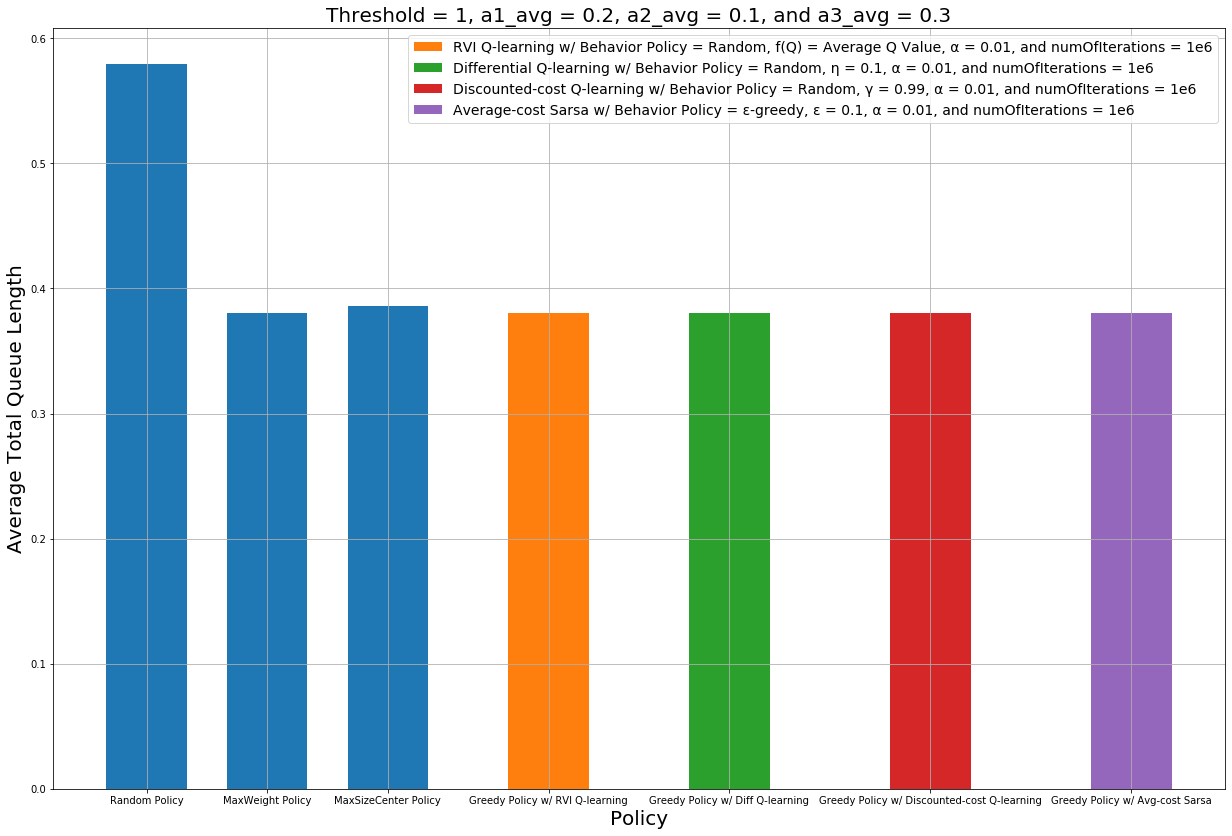

In [5]:
c = 1
a1_avg, a2_avg, a3_avg = 0.2, 0.1, 0.3
numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa = int(1e6), int(1e6), int(1e6)

performanceComparison(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa)

Random policy gives
average total queue length ≈ 1.1367175

MaxWeight policy gives
average total queue length ≈ 0.91416

MaxSizeCenter policy gives
average total queue length ≈ 1.002285

For alpha = 0.01 and numOfIterations = 1e6, RVI q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.91416

For eta = 0.1, alpha = 0.01, and numOfIterations = 1e6, differential q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.91416

For gamma = 0.99, alpha = 0.01, and numOfIterations = 1e6, discounted-cost q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.91416

For epsilon = 0.1, alpha = 0.01, and numOfIterations = 1e6, average-cost Sarsa gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.91416



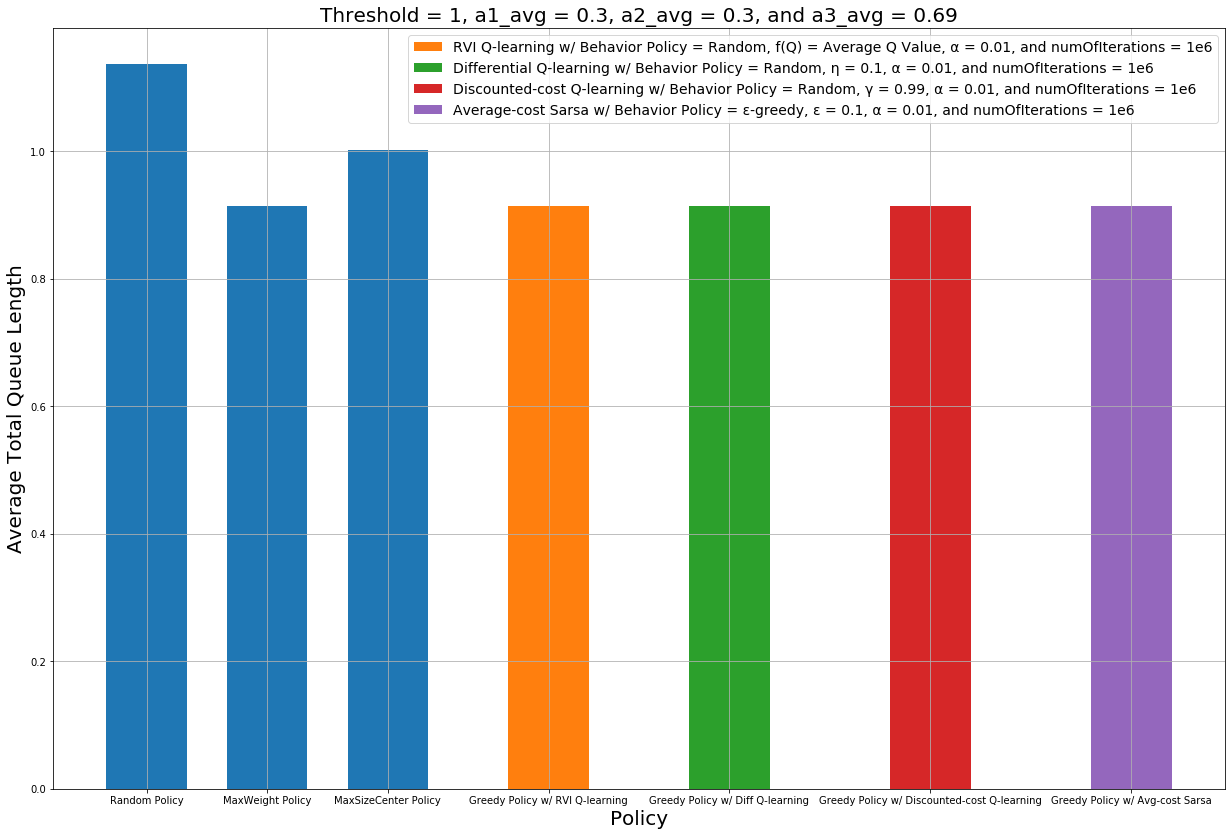

In [6]:
c = 1
a1_avg, a2_avg, a3_avg = 0.3, 0.3, 0.69
numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa = int(1e6), int(1e6), int(1e6)

performanceComparison(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa)

Random policy gives
average total queue length ≈ 1.54156

MaxWeight policy gives
average total queue length ≈ 1.0392275

MaxSizeCenter policy gives
average total queue length ≈ 1.01962

For alpha = 0.01 and numOfIterations = 5e6, RVI q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.9817325

For eta = 0.1, alpha = 0.01, and numOfIterations = 5e6, differential q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.9817325

For gamma = 0.99, alpha = 0.01, and numOfIterations = 5e6, discounted-cost q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.9817325

For epsilon = 0.1, alpha = 0.01, and numOfIterations = 5e6, average-cost Sarsa gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 0.9817325



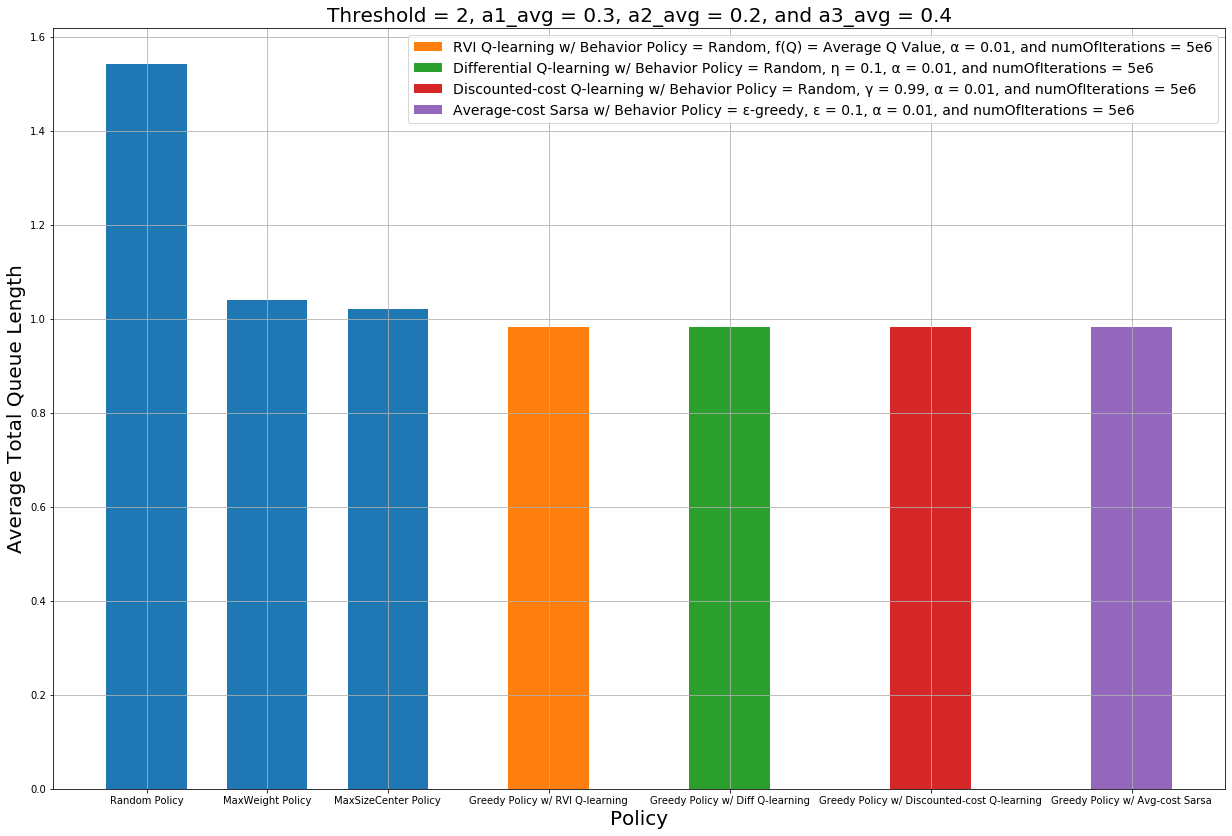

In [7]:
c = 2
a1_avg, a2_avg, a3_avg = 0.3, 0.2, 0.4
numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa = int(5e6), int(5e6), int(5e6)

performanceComparison(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa)

Random policy gives
average total queue length ≈ 2.2667575

MaxWeight policy gives
average total queue length ≈ 1.9556825

MaxSizeCenter policy gives
average total queue length ≈ 2.0257975

For alpha = 0.01 and numOfIterations = 1e6, RVI q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 1.7015775

For eta = 0.1, alpha = 0.01, and numOfIterations = 1e6, differential q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 1.7015775

For gamma = 0.99, alpha = 0.01, and numOfIterations = 2e6, discounted-cost q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 1.7015775

For epsilon = 0.1, alpha = 0.01, and numOfIterations = 1e6, average-cost Sarsa gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 1.7015775



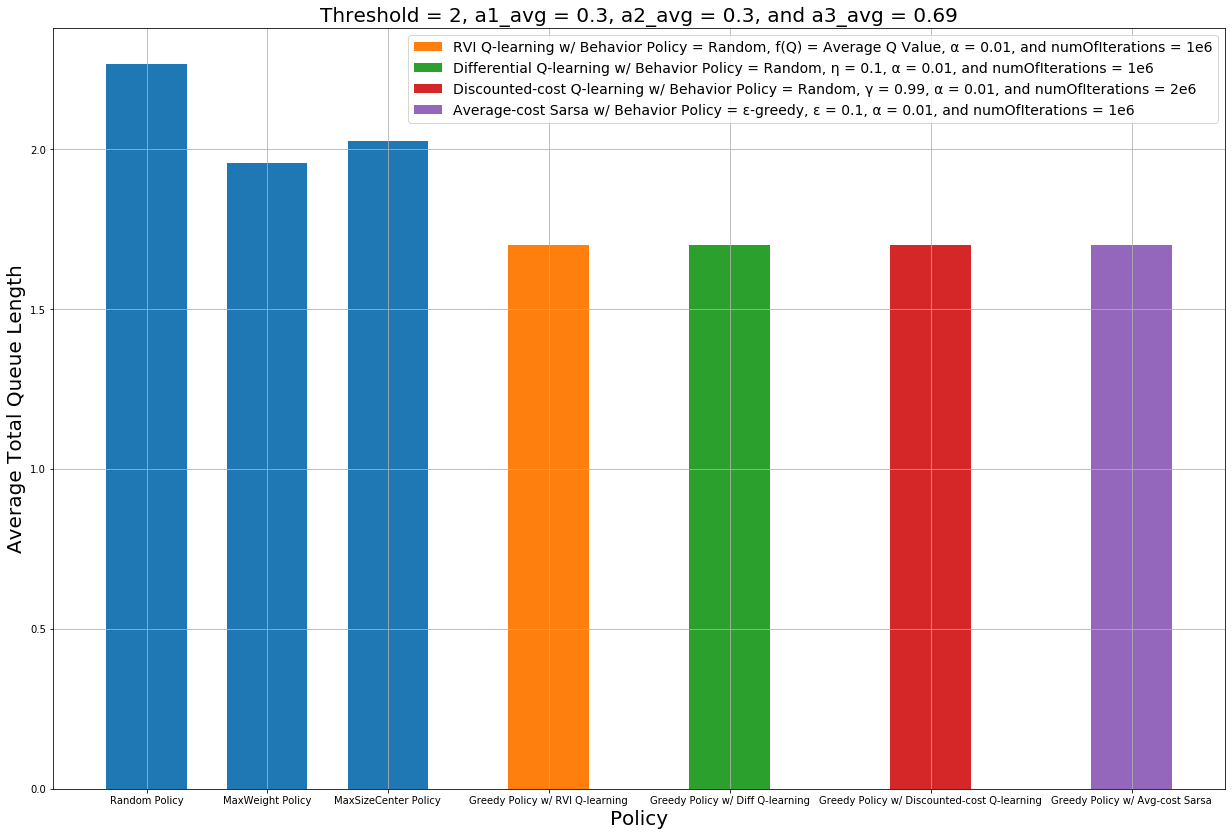

In [8]:
c = 2
a1_avg, a2_avg, a3_avg = 0.3, 0.3, 0.69
numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa = int(1e6), int(2e6), int(1e6)

performanceComparison(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa)

Random policy gives
average total queue length ≈ 3.138485

MaxWeight policy gives
average total queue length ≈ 2.4940725

MaxSizeCenter policy gives
average total queue length ≈ 2.2567675

For alpha = 0.01 and numOfIterations = 5e6, RVI q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.1151375

For eta = 0.1, alpha = 0.01, and numOfIterations = 5e6, differential q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.1151375

For gamma = 0.99, alpha = 0.01, and numOfIterations = 5e6, discounted-cost q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.1151375

For epsilon = 0.1, alpha = 0.01, and numOfIterations = 50e6, average-cost Sarsa gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.1151375



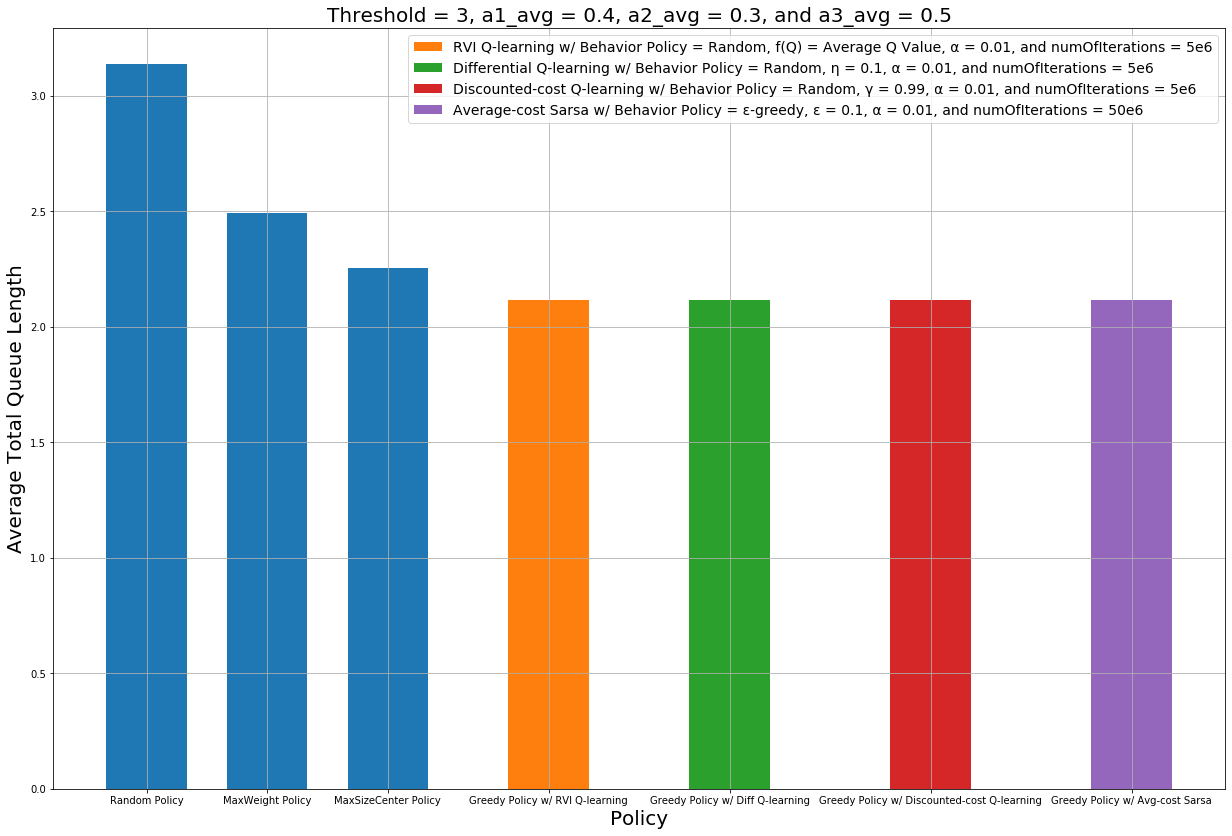

In [9]:
c = 3
a1_avg, a2_avg, a3_avg = 0.4, 0.3, 0.5
numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa = int(5e6), int(5e6), int(50e6)

performanceComparison(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa)

Random policy gives
average total queue length ≈ 3.336735

MaxWeight policy gives
average total queue length ≈ 3.029735

MaxSizeCenter policy gives
average total queue length ≈ 2.92627

For alpha = 0.01 and numOfIterations = 5e6, RVI q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.40605

For eta = 0.1, alpha = 0.01, and numOfIterations = 5e6, differential q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.40605

For gamma = 0.99, alpha = 0.01, and numOfIterations = 5e6, discounted-cost q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.40605

For epsilon = 0.1, alpha = 0.0025, and numOfIterations = 100e6, average-cost Sarsa gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.40605



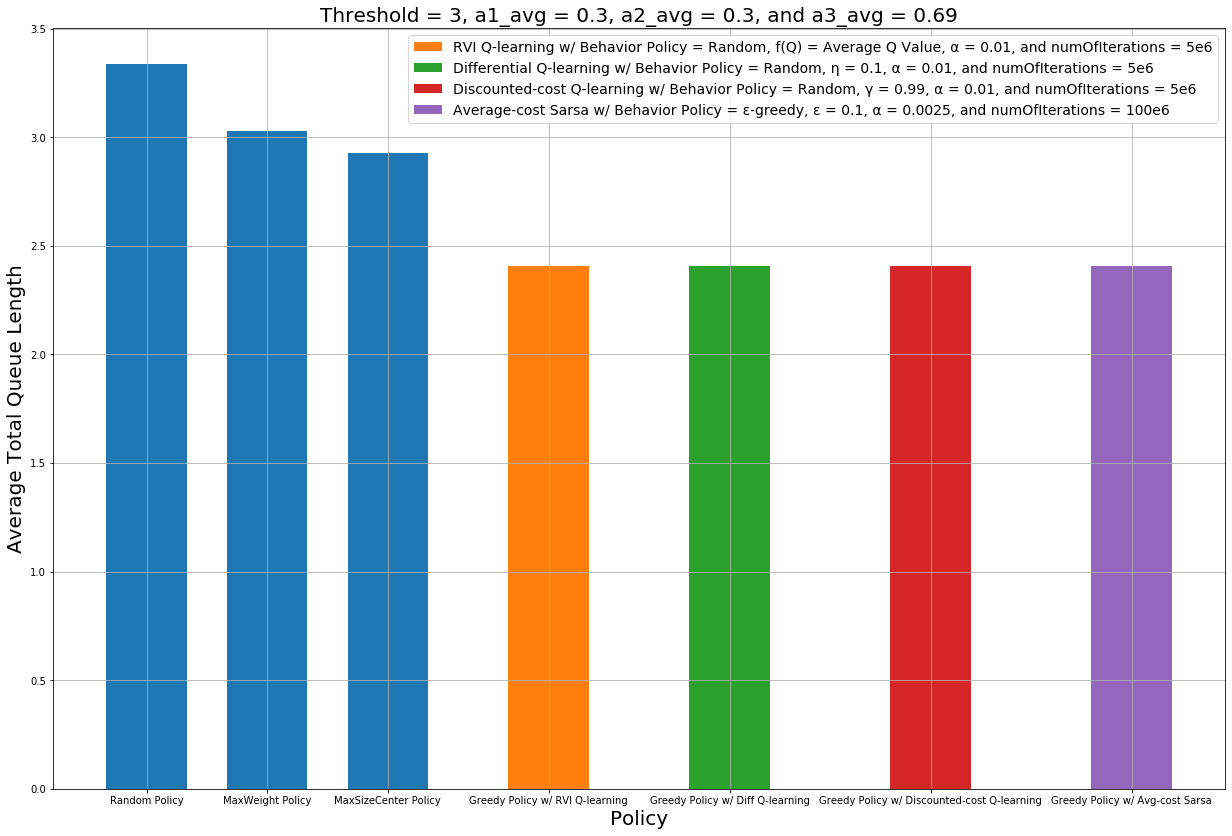

In [10]:
c = 3
a1_avg, a2_avg, a3_avg = 0.3, 0.3, 0.69
numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa = int(5e6), int(5e6), int(100e6)
alphaForDis, alphaForSarsa = 0.01, 0.0025
epsilonForSarsa = 0.1

performanceComparisonAdvanced(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa, alphaForDis, alphaForSarsa, epsilonForSarsa)

Random policy gives
average total queue length ≈ 4.0272625

MaxWeight policy gives
average total queue length ≈ 3.16799

MaxSizeCenter policy gives
average total queue length ≈ 2.7257975

For alpha = 0.01 and numOfIterations = 100e6, RVI q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.56881

For eta = 0.1, alpha = 0.01, and numOfIterations = 100e6, differential q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.56881

For gamma = 0.99, alpha = 0.01, and numOfIterations = 100e6, discounted-cost q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.568715

For epsilon = 0.1, alpha = 0.01, and numOfIterations = 100e6, average-cost Sarsa gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 2.5672075



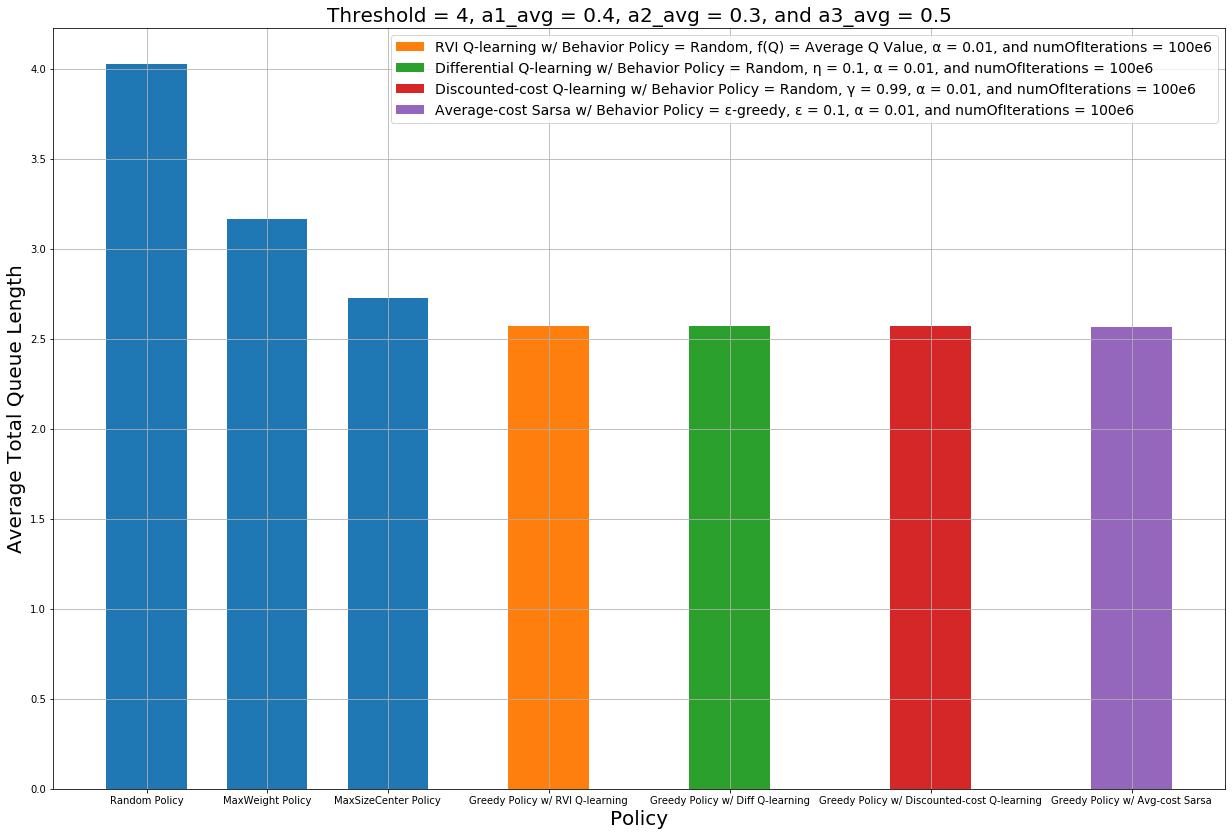

In [11]:
c = 4
a1_avg, a2_avg, a3_avg = 0.4, 0.3, 0.5
numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa = int(100e6), int(100e6), int(100e6)

performanceComparison(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa)

Random policy gives
average total queue length ≈ 4.3633425

MaxWeight policy gives
average total queue length ≈ 4.1297025

MaxSizeCenter policy gives
average total queue length ≈ 3.75844

For alpha = 0.01 and numOfIterations = 5e6, RVI q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.1, alpha = 0.01, and numOfIterations = 5e6, differential q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For gamma = 0.99, alpha = 0.01, and numOfIterations = 20e6, discounted-cost q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For epsilon = 0.1, alpha = 0.01, and numOfIterations = 100e6, average-cost Sarsa gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725



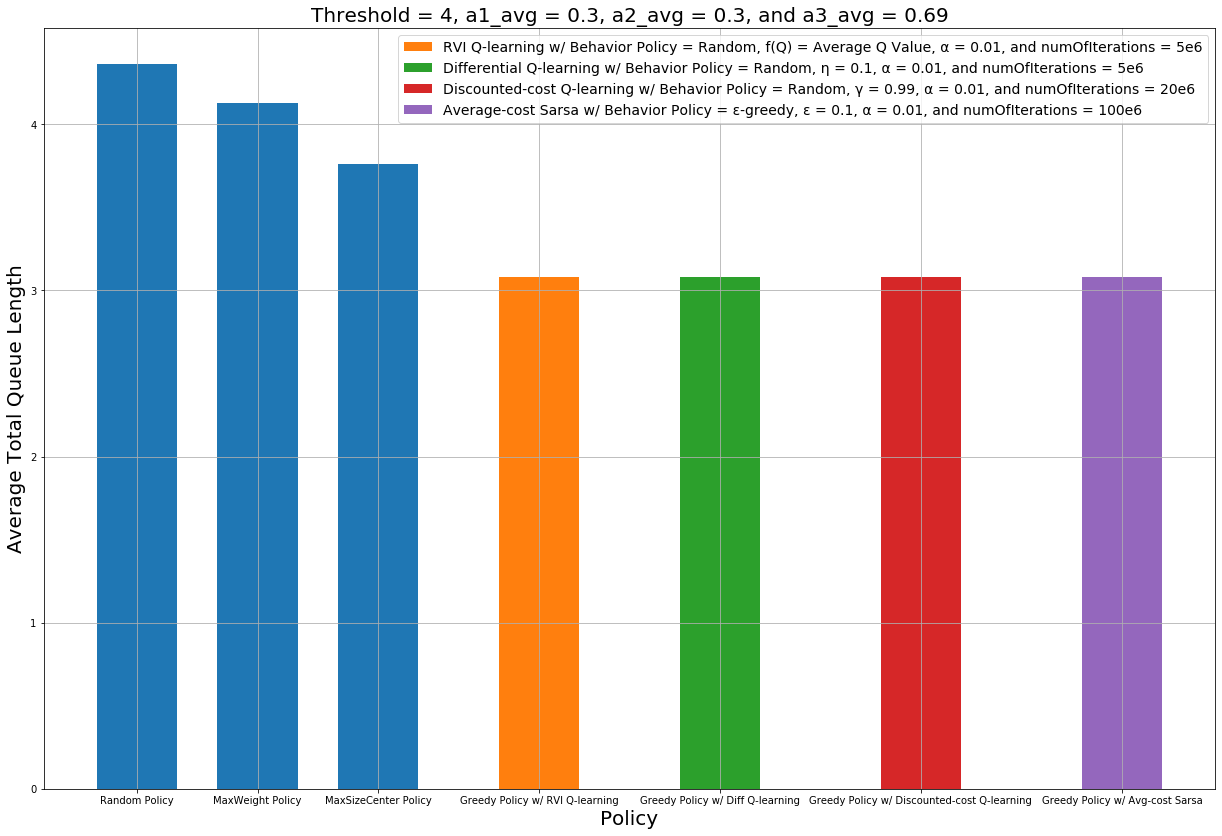

In [12]:
c = 4
a1_avg, a2_avg, a3_avg = 0.3, 0.3, 0.69
numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa = int(5e6), int(20e6), int(100e6)

performanceComparison(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa)

Random policy gives
average total queue length ≈ 8.28668

MaxWeight policy gives
average total queue length ≈ 8.5805975

MaxSizeCenter policy gives
average total queue length ≈ 6.8900525

For alpha = 0.01 and numOfIterations = 500e6, RVI q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 5.6331025

For eta = 0.1, alpha = 0.01, and numOfIterations = 500e6, differential q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 5.6336575

For gamma = 0.99, alpha = 0.025, and numOfIterations = 500e6, discounted-cost q-learning gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 5.63494

For epsilon = 0.05, alpha = 0.01, and numOfIterations = 2000e6, average-cost Sarsa gives
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 5.6346475



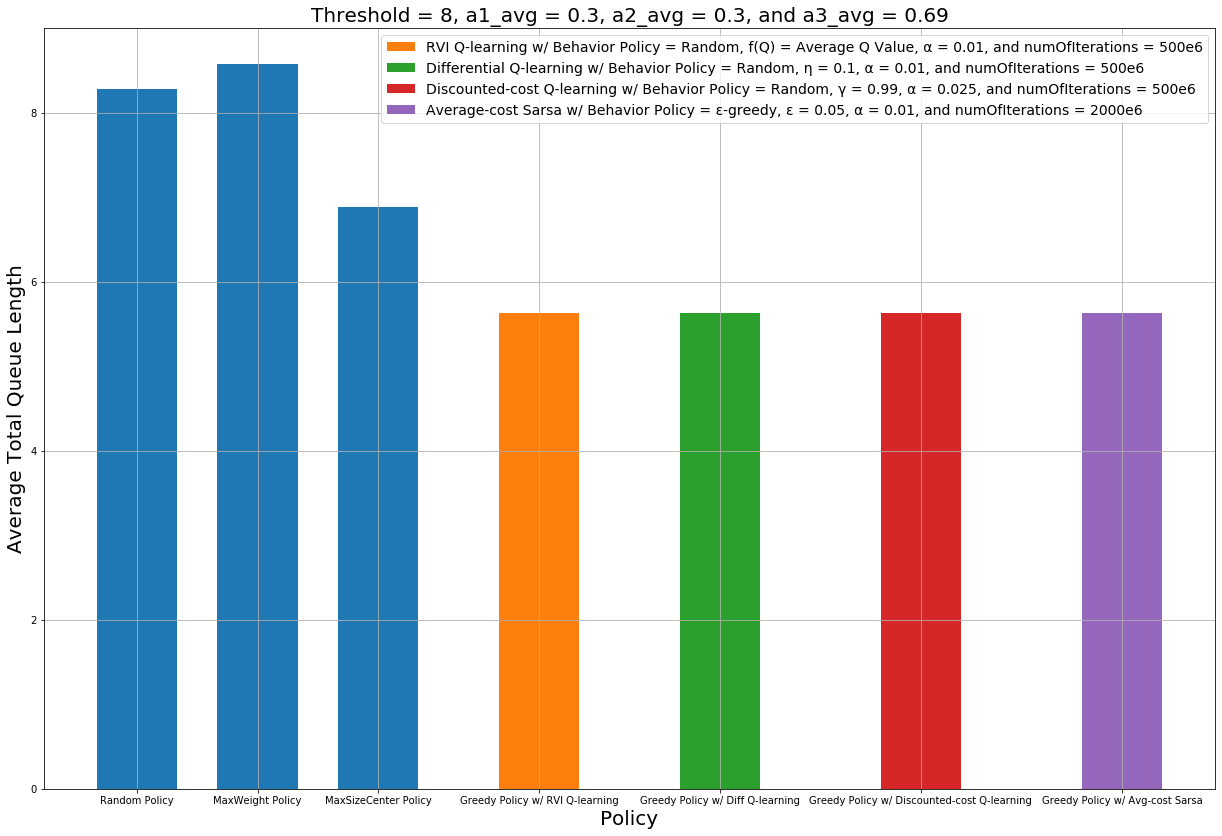

In [13]:
c = 8
a1_avg, a2_avg, a3_avg = 0.3, 0.3, 0.69
numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa = int(500e6), int(500e6), int(2000e6)
alphaForDis, alphaForSarsa = 0.025, 0.01
epsilonForSarsa = 0.05

performanceComparisonAdvanced(c, a1_avg, a2_avg, a3_avg, numOfIterationsForRVIDiff, numOfIterationsForDis, numOfIterationsForSarsa, alphaForDis, alphaForSarsa, epsilonForSarsa)